In [154]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Importing CSVs and Slicing the correct experimental time

In [2]:

# Read the primary CSV file
experiment_data = pd.read_csv('experiments.csv')

# Extract relevant columns
experiment_data = experiment_data[['chaosresult_name', 'Experiment Start', 'Chaos Injected', 'Experiment End']]

# Convert timestamps to datetime and rename columns
experiment_data['Experiment Start'] = pd.to_datetime(experiment_data['Experiment Start'], unit='ms')
experiment_data['Chaos Injected'] = pd.to_datetime(experiment_data['Chaos Injected'], unit='ms')
experiment_data['Experiment End'] = pd.to_datetime(experiment_data['Experiment End'], unit='ms')
experiment_data.rename(columns={'Experiment Start': 'start_time', 'Chaos Injected': 'inject_change', 'Experiment End': 'end_time'}, inplace=True)

# Adding two hours to all timestamps in experiments DataFrame because of time zone difference
experiment_data['start_time'] = experiment_data['start_time'] + pd.Timedelta(hours=2)
experiment_data['inject_change'] = experiment_data['inject_change'] + pd.Timedelta(hours=2)
experiment_data['end_time'] = experiment_data['end_time'] + pd.Timedelta(hours=2)


# Convert your cutoff time to a datetime object
cutoff_time = pd.to_datetime('2023-07-15 18:05:27')

# Filter the experiments DataFrame
experiment_data = experiment_data[experiment_data['start_time'] > cutoff_time]

print(experiment_data.head())



                   chaosresult_name          start_time       inject_change  \
0  pod-cpu-hog-1lybh4rx-pod-cpu-hog 2023-07-16 12:20:28 2023-07-16 12:22:43   
1  pod-cpu-hog-1lyfsbkd-pod-cpu-hog 2023-07-15 23:22:22 2023-07-15 23:24:37   
2  pod-cpu-hog-39bc9kkf-pod-cpu-hog 2023-07-16 12:26:39 2023-07-16 12:28:54   
3  pod-cpu-hog-39bpcttl-pod-cpu-hog 2023-07-15 23:28:34 2023-07-15 23:30:50   
4  pod-cpu-hog-4z649dhv-pod-cpu-hog 2023-07-15 23:34:46 2023-07-15 23:37:01   

             end_time  
0 2023-07-16 12:25:58  
1 2023-07-15 23:27:52  
2 2023-07-16 12:32:10  
3 2023-07-15 23:34:04  
4 2023-07-15 23:40:16  


### Importing the non-litmus experiments

In [3]:
import glob
import re

# Get a list of all the files matching the pattern "perform_update_X.txt"
file_list = glob.glob("perform_update_*.txt")

experiment = []

# Iterate over the file list
for file_name in file_list:
    # Read the file and extract the relevant information
    with open(file_name, "r") as file:
        # Read the lines from the file
        lines = file.readlines()

        start_time = None
        inject_change = None
        end_time = None

        for line in lines:
            line = line.strip()

            if line.startswith('Start Trial'):
                start_time = re.search(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', line).group()
                trial_number = int(re.search(r'Start Trial (\d+)', line).group(1))
            elif line.startswith('Update pushed'):
                inject_change = re.search(r'Update pushed: (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', line).group(1)

            elif line.startswith('Trial'):
                end_time = re.search(r'Trial \d+ over (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', line).group(1)
                # Create a dictionary representing the trial information
                trial_data = {
                    'chaosresult_name': f'{file_name.split(".")[0]}_Trial{trial_number}',
                    'start_time': pd.to_datetime(start_time),
                    'inject_change': pd.to_datetime(inject_change),
                    'end_time': pd.to_datetime(end_time)
                }
                # Append the trial data to the list
                experiment.append(trial_data)

# Create a DataFrame from the extracted trial data
update_experiments = pd.DataFrame(experiment)

update_experiments.style


# Concatenate the new data with the existing experiment_data DataFrame
experiment_data = pd.concat([experiment_data, update_experiments], ignore_index=True)

In [4]:
# Get a list of all the files matching the pattern "perform_update_X.txt"
file_list = glob.glob("increase_load_*.txt")

experiment = []

# Iterate over the file list
for file_name in file_list:
    # Read the file and extract the relevant information
    with open(file_name, "r") as file:
        # Read the lines from the file
        lines = file.readlines()

        start_time = None
        inject_change = None
        end_time = None

        for line in lines:
            line = line.strip()

            if line.startswith('-------------Start Trial'):
                start_time = re.search(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', line).group()
                trial_number = int(re.search(r'-------------Start Trial (\d+)', line).group(1))
            elif line.startswith('-------------Chaos injected'):
                inject_change = re.search(r'-------------Chaos injected: (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', line).group(1)

            elif line.startswith('-------------Trial'):
                end_time = re.search(r'-------------Trial \d+ over (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', line).group(1)
                # Create a dictionary representing the trial information
                trial_data = {
                    'chaosresult_name': f'{file_name.split(".")[0]}_Trial{trial_number}',
                    'start_time': pd.to_datetime(start_time),
                    'inject_change': pd.to_datetime(inject_change),
                    'end_time': pd.to_datetime(end_time)
                }
                # Append the trial data to the list
                experiment.append(trial_data)

# Create a DataFrame from the extracted trial data
update_experiments = pd.DataFrame(experiment)

update_experiments.style


# Concatenate the new data with the existing experiment_data DataFrame
experiment_data = pd.concat([experiment_data, update_experiments], ignore_index=True)

In [5]:
# Get the start time of the first experiment
first_start_time = experiment_data['start_time'].min()
print(f"The start time of the first experiment is: {first_start_time}")

# Get the end time of the last experiment
last_end_time = experiment_data['end_time'].max()
print(f"The end time of the last experiment is: {last_end_time}")

experiment_data[experiment_data['end_time']==experiment_data['end_time'].max()]

The start time of the first experiment is: 2023-07-15 18:05:27
The end time of the last experiment is: 2023-07-16 16:35:57


,chaosresult_name,start_time,inject_change,end_time
119,perform_update_2_Trial10,2023-07-16 16:32:54,2023-07-16 16:33:27,2023-07-16 16:35:57


## Prepare the experiments

In [6]:
# Define a function to extract the type from the chaosresult_name
def get_type(name):
    if 'cpu' in name:
        return 'cpu'
    elif 'memory' in name:
        return 'memory'
    elif 'network' in name:
        return 'network'
    elif 'delete' in name:
        return 'delete'
    elif 'update' in name:
        return 'update'
    elif 'load' in name:
        return 'load'
    else:
        return 'unknown'

# Apply this function to the chaosresult_name column to create a new type column
experiment_data['type'] = experiment_data['chaosresult_name'].apply(get_type)

# Sort by start_time
experiment_data = experiment_data.sort_values(by='start_time')

# Create a new 'group' column
experiment_data['group'] = experiment_data.groupby('type').cumcount() // 10

print(experiment_data.head())


            chaosresult_name          start_time       inject_change  \
100  perform_update_1_Trial1 2023-07-15 18:05:27 2023-07-15 18:06:00   
101  perform_update_1_Trial2 2023-07-15 18:08:30 2023-07-15 18:09:03   
102  perform_update_1_Trial3 2023-07-15 18:11:33 2023-07-15 18:12:06   
103  perform_update_1_Trial4 2023-07-15 18:14:36 2023-07-15 18:15:08   
104  perform_update_1_Trial5 2023-07-15 18:17:38 2023-07-15 18:18:11   

               end_time    type  group  
100 2023-07-15 18:08:30  update      0  
101 2023-07-15 18:11:33  update      0  
102 2023-07-15 18:14:36  update      0  
103 2023-07-15 18:17:38  update      0  
104 2023-07-15 18:20:41  update      0  


In [7]:
# Check the number of trials in each group for each type
trial_counts = experiment_data.groupby(['type', 'group']).size()

# Print the counts
print(trial_counts)


type     group
cpu      0        10
         1        10
delete   0        10
load     0        10
         1        10
memory   0        10
         1        10
         2        10
         3        10
network  0        10
         1        10
         2        10
update   0        10
         1        10
dtype: int64


In [8]:
# Group by type and group, and get the count of trials and the start time of the first trial
group_info = experiment_data.groupby(['type', 'group']).agg(
    trial_count=pd.NamedAgg(column='chaosresult_name', aggfunc='size'),
    first_trial_start=pd.NamedAgg(column='start_time', aggfunc='min')
)

# Filter groups that do not have exactly 10 trials
incomplete_groups = group_info[group_info['trial_count'] != 10]

# Print the start time of the first trial for these groups
print(incomplete_groups['first_trial_start'])


Series([], Name: first_trial_start, dtype: datetime64[ns])


## Importing the request data from grafana

In [9]:
# Get a list of all inbound and outbound traffic CSV files
inbound_files = glob.glob('inbound_traffic_*.csv')
outbound_files = glob.glob('outbound_traffic_*.csv')

# Read and concatenate all inbound and outbound traffic CSV files
inbound_traffic = pd.concat((pd.read_csv(f, parse_dates=['Time']) for f in inbound_files))
outbound_traffic = pd.concat((pd.read_csv(f, parse_dates=['Time']) for f in outbound_files))

# Drop duplicates
inbound_traffic = inbound_traffic.drop_duplicates(subset='Time')
outbound_traffic = outbound_traffic.drop_duplicates(subset='Time')

# Rename Column Name
outbound_traffic = outbound_traffic.rename(columns={"Response Within Response Time": "SRinT/SR"})
inbound_traffic = inbound_traffic.rename(columns={"Response Within Response Time": "SRinT/SR"})


# Convert the 'Response Within Response Time' columns to ratios
outbound_traffic['SRinT/SR'] = outbound_traffic['SRinT/SR'].str.rstrip('%').astype('float') / 100.0
inbound_traffic['SRinT/SR'] = inbound_traffic['SRinT/SR'].str.rstrip('%').astype('float') / 100.0


In [10]:
outbound_traffic[outbound_traffic.duplicated()]

,Time,SRinT/SR


In [11]:
inbound_traffic[inbound_traffic.duplicated(['Time'])]

,Time,SRinT/SR


In [12]:
inbound_traffic.describe()

,Time,SRinT/SR
count,9093,9093.000000
mean,2023-07-16 05:27:40,0.983247
min,2023-07-15 16:50:00,0.795000
25%,2023-07-15 23:08:50,0.979000
50%,2023-07-16 05:27:40,0.993000
75%,2023-07-16 11:46:30,1.000000
max,2023-07-16 18:05:20,1.000000
std,NaN,0.026078


In [13]:
def calculate_timestamp(start_time, end_time, next_time, data, condition):
    subset = data[(data['Time'] >= start_time) & (data['Time'] <= end_time) & condition]
    if not subset.empty:
        index = subset['Time'].idxmin()
        return subset.loc[index, 'Time']
    return pd.NaT

def calculate_fail_timestamps(row):
    # Calculate 'fail_init'
    outbound_subset = outbound_traffic[(outbound_traffic['Time'] >= row['inject_change']) & (outbound_traffic['Time'] <= row['end_time']) & (outbound_traffic['SRinT/SR'] < 0.95)]
    outbound_subset.reset_index(drop=True, inplace=True)
    fail_init = calculate_timestamp(row['inject_change'], row['end_time'], pd.NaT, outbound_subset, True)

    # Calculate 'fail_end'
    next_trial_inject_change = experiment_data.loc[row.name + 1, 'inject_change'] if row.name < len(experiment_data) - 1 else pd.NaT
    if pd.isna(fail_init):
        fail_end = pd.NaT
    else:
        outbound_subset = outbound_traffic[(outbound_traffic['Time'] >= fail_init) & (outbound_traffic['Time'] <= next_trial_inject_change) & (outbound_traffic['SRinT/SR'] > 0.95)]
        outbound_subset.reset_index(drop=True, inplace=True)
        fail_end = calculate_timestamp(fail_init, next_trial_inject_change, row['end_time'], outbound_subset, True)

    # Calculate 'fail_detect'
    if pd.isna(row['inject_change']):
        fail_detect = pd.NaT
    else:
        inbound_subset = inbound_traffic[(inbound_traffic['Time'] >= (row['inject_change'] + pd.Timedelta(seconds=20))) & (inbound_traffic['Time'] <= row['end_time']) & (inbound_traffic['SRinT/SR'] < 0.95)]
        inbound_subset.reset_index(drop=True, inplace=True)
        fail_detect = calculate_timestamp(row['inject_change'] + pd.Timedelta(seconds=20), row['end_time'], pd.NaT, inbound_subset, True)

    if pd.isna(fail_init) and not pd.isna(fail_detect):
        print(f"Warning: False positive failure detection at {fail_detect} for trial {row.name}. Setting fail_detect to NA.")
        fail_detect = pd.NaT
        
    return pd.Series([fail_init, fail_end, fail_detect])



In [14]:
# Reset the index of the experiment_data DataFrame
experiment_data.reset_index(drop=True, inplace=True)

experiment_data[['fail_init', 'fail_end', 'fail_detect']] = experiment_data.apply(calculate_fail_timestamps, axis=1)


In [15]:
experiment_data.describe()

,start_time,inject_change,end_time,group,fail_init,fail_end,fail_detect
count,140,140,140,140.000000,56,55,31
mean,2023-07-16 05:16:31.221428480,2023-07-16 05:18:35.135714304,2023-07-16 05:21:57.214285824,0.857143,2023-07-16 03:17:48.392857088,2023-07-16 03:28:28,2023-07-16 01:47:52.903225856
min,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,0.000000,2023-07-15 18:52:40,2023-07-15 18:54:50,2023-07-15 18:52:40
25%,2023-07-15 21:54:14.750000128,2023-07-15 21:56:30,2023-07-15 21:59:47.750000128,0.000000,2023-07-15 21:11:45,2023-07-15 21:34:30,2023-07-15 19:29:25
50%,2023-07-16 05:06:29,2023-07-16 05:10:03.500000,2023-07-16 05:12:56,1.000000,2023-07-16 00:41:25,2023-07-16 00:46:30,2023-07-15 23:32:50
75%,2023-07-16 12:28:12,2023-07-16 12:30:27,2023-07-16 12:33:42.750000128,1.000000,2023-07-16 10:07:12.500000,2023-07-16 10:09:35,2023-07-16 09:33:00
max,2023-07-16 16:32:54,2023-07-16 16:33:27,2023-07-16 16:35:57,3.000000,2023-07-16 15:02:40,2023-07-16 15:03:10,2023-07-16 13:02:20
std,NaN,NaN,NaN,0.918017,NaN,NaN,NaN


In [16]:
experiment_data.style

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect
0,perform_update_1_Trial1,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,update,0,NaT,NaT,NaT
1,perform_update_1_Trial2,2023-07-15 18:08:30,2023-07-15 18:09:03,2023-07-15 18:11:33,update,0,NaT,NaT,NaT
2,perform_update_1_Trial3,2023-07-15 18:11:33,2023-07-15 18:12:06,2023-07-15 18:14:36,update,0,NaT,NaT,NaT
3,perform_update_1_Trial4,2023-07-15 18:14:36,2023-07-15 18:15:08,2023-07-15 18:17:38,update,0,NaT,NaT,NaT
4,perform_update_1_Trial5,2023-07-15 18:17:38,2023-07-15 18:18:11,2023-07-15 18:20:41,update,0,NaT,NaT,NaT
5,perform_update_1_Trial6,2023-07-15 18:20:41,2023-07-15 18:21:14,2023-07-15 18:23:44,update,0,NaT,NaT,NaT
6,perform_update_1_Trial7,2023-07-15 18:23:44,2023-07-15 18:24:17,2023-07-15 18:26:47,update,0,NaT,NaT,NaT
7,perform_update_1_Trial8,2023-07-15 18:26:47,2023-07-15 18:27:19,2023-07-15 18:29:49,update,0,NaT,NaT,NaT
8,perform_update_1_Trial9,2023-07-15 18:29:49,2023-07-15 18:30:22,2023-07-15 18:32:52,update,0,NaT,NaT,NaT
9,perform_update_1_Trial10,2023-07-15 18:32:52,2023-07-15 18:33:24,2023-07-15 18:35:54,update,0,NaT,NaT,NaT


In [17]:
# Filter trials where fail_end is after end_time
failed_trials = experiment_data[experiment_data['fail_detect'] < experiment_data['fail_init']]

# Print the failed trials
failed_trials.style

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect
41,pod-cpu-hog-y53vjl6b-pod-cpu-hog,2023-07-15 23:09:57,2023-07-15 23:12:12,2023-07-15 23:15:27,cpu,0,2023-07-15 23:14:20,2023-07-15 23:16:30,2023-07-15 23:12:40
45,pod-cpu-hog-4z649dhv-pod-cpu-hog,2023-07-15 23:34:46,2023-07-15 23:37:01,2023-07-15 23:40:16,cpu,0,2023-07-15 23:37:40,2023-07-15 23:41:40,2023-07-15 23:37:30
46,pod-cpu-hog-7oyr7h5g-pod-cpu-hog,2023-07-15 23:40:58,2023-07-15 23:43:13,2023-07-15 23:46:28,cpu,0,2023-07-15 23:44:40,2023-07-15 23:49:00,2023-07-15 23:44:00
47,pod-cpu-hog-9o7lzbf5-pod-cpu-hog,2023-07-15 23:47:09,2023-07-15 23:49:25,2023-07-15 23:52:39,cpu,0,2023-07-15 23:51:00,2023-07-15 23:53:40,2023-07-15 23:49:50
48,pod-cpu-hog-bquk5dwr-pod-cpu-hog,2023-07-15 23:53:21,2023-07-15 23:55:36,2023-07-15 23:58:51,cpu,0,2023-07-15 23:57:20,2023-07-16 00:00:00,2023-07-15 23:56:00
81,increase_load_2_Trial2,2023-07-16 09:29:02,2023-07-16 09:30:02,2023-07-16 09:34:02,load,1,2023-07-16 09:31:00,2023-07-16 09:31:10,2023-07-16 09:30:30
82,increase_load_2_Trial3,2023-07-16 09:34:02,2023-07-16 09:35:02,2023-07-16 09:39:02,load,1,2023-07-16 09:37:20,2023-07-16 09:38:30,2023-07-16 09:35:30
104,pod-cpu-hog-39bc9kkf-pod-cpu-hog,2023-07-16 12:26:39,2023-07-16 12:28:54,2023-07-16 12:32:10,cpu,1,2023-07-16 12:29:30,2023-07-16 12:31:40,2023-07-16 12:29:20


In [18]:
# Filter trials where fail_end is NaT
failed_trials = experiment_data[pd.isna(experiment_data['fail_end'])]

# Print the failed trials
failed_trials.style

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect
0,perform_update_1_Trial1,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,update,0,NaT,NaT,NaT
1,perform_update_1_Trial2,2023-07-15 18:08:30,2023-07-15 18:09:03,2023-07-15 18:11:33,update,0,NaT,NaT,NaT
2,perform_update_1_Trial3,2023-07-15 18:11:33,2023-07-15 18:12:06,2023-07-15 18:14:36,update,0,NaT,NaT,NaT
3,perform_update_1_Trial4,2023-07-15 18:14:36,2023-07-15 18:15:08,2023-07-15 18:17:38,update,0,NaT,NaT,NaT
4,perform_update_1_Trial5,2023-07-15 18:17:38,2023-07-15 18:18:11,2023-07-15 18:20:41,update,0,NaT,NaT,NaT
5,perform_update_1_Trial6,2023-07-15 18:20:41,2023-07-15 18:21:14,2023-07-15 18:23:44,update,0,NaT,NaT,NaT
6,perform_update_1_Trial7,2023-07-15 18:23:44,2023-07-15 18:24:17,2023-07-15 18:26:47,update,0,NaT,NaT,NaT
7,perform_update_1_Trial8,2023-07-15 18:26:47,2023-07-15 18:27:19,2023-07-15 18:29:49,update,0,NaT,NaT,NaT
8,perform_update_1_Trial9,2023-07-15 18:29:49,2023-07-15 18:30:22,2023-07-15 18:32:52,update,0,NaT,NaT,NaT
9,perform_update_1_Trial10,2023-07-15 18:32:52,2023-07-15 18:33:24,2023-07-15 18:35:54,update,0,NaT,NaT,NaT


In [19]:
# Filter trials where fail_end is NaT but fail_init is not NaT
failed_trials = experiment_data[pd.isna(experiment_data['fail_init']) & ~pd.isna(experiment_data['fail_detect'])]

# Print the failed trials
failed_trials.head()

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect


In [20]:
failed_trials.style

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect


In [21]:
print(experiment_data)

             chaosresult_name          start_time       inject_change  \
0     perform_update_1_Trial1 2023-07-15 18:05:27 2023-07-15 18:06:00   
1     perform_update_1_Trial2 2023-07-15 18:08:30 2023-07-15 18:09:03   
2     perform_update_1_Trial3 2023-07-15 18:11:33 2023-07-15 18:12:06   
3     perform_update_1_Trial4 2023-07-15 18:14:36 2023-07-15 18:15:08   
4     perform_update_1_Trial5 2023-07-15 18:17:38 2023-07-15 18:18:11   
..                        ...                 ...                 ...   
135   perform_update_2_Trial6 2023-07-16 16:20:43 2023-07-16 16:21:16   
136   perform_update_2_Trial7 2023-07-16 16:23:46 2023-07-16 16:24:19   
137   perform_update_2_Trial8 2023-07-16 16:26:49 2023-07-16 16:27:21   
138   perform_update_2_Trial9 2023-07-16 16:29:51 2023-07-16 16:30:24   
139  perform_update_2_Trial10 2023-07-16 16:32:54 2023-07-16 16:33:27   

               end_time    type  group fail_init fail_end fail_detect  
0   2023-07-15 18:08:30  update      0       NaT   

## Calculate the Metrics

In [22]:
# Concatenate all login request csv files
all_login_files = glob.glob('login_requests_*.csv')
login_df_list = []

for filename in all_login_files:
    df = pd.read_csv(filename, parse_dates=['Time'])
    login_df_list.append(df)

login_df = pd.concat(login_df_list, axis=0, ignore_index=True)

login_df = login_df.drop_duplicates(subset='Time')

# Concatenate all slo csv files
all_slo_files = glob.glob('slo_*.csv')
slo_df_list = []

for filename in all_slo_files:
    df = pd.read_csv(filename, parse_dates=['Time'])
    slo_df_list.append(df)

    
print(slo_df_list)
slo_df = pd.concat(slo_df_list, axis=0, ignore_index=True)

slo_df = slo_df.drop_duplicates(subset='Time')


[                   Time GET /login 20ms GET /signup 20ms POST /logout 20ms  \
0   2023-07-15 16:50:00            100%             100%              100%   
1   2023-07-15 16:50:10            100%             100%              100%   
2   2023-07-15 16:50:20            100%             100%              100%   
3   2023-07-15 16:50:30            100%             100%               NaN   
4   2023-07-15 16:50:40             NaN             100%              100%   
..                  ...             ...              ...               ...   
704 2023-07-15 18:49:20            100%             100%              100%   
705 2023-07-15 18:49:30            100%             100%               NaN   
706 2023-07-15 18:49:40            100%             100%              100%   
707 2023-07-15 18:49:50            100%             100%               NaN   
708 2023-07-15 18:50:00            100%             100%              100%   

    GET / 30ms GET /home 30ms POST /deposit 300ms POST /paymen

In [23]:
print(login_df)

                    Time  POST /login (SRinT)  POST /login (SR)
0    2023-07-15 16:50:00                  0.5               0.5
1    2023-07-15 16:50:10                  0.6               0.6
2    2023-07-15 16:50:20                  0.7               0.7
3    2023-07-15 16:50:30                  0.8               0.8
4    2023-07-15 16:50:40                  0.9               0.9
...                  ...                  ...               ...
8974 2023-07-16 10:04:30                  0.4               0.4
8975 2023-07-16 10:04:40                  0.5               0.6
8976 2023-07-16 10:04:50                  0.4               0.4
8977 2023-07-16 10:05:00                  0.4               0.4
8978 2023-07-16 10:05:10                  0.5               0.5

[8969 rows x 3 columns]


In [24]:
# Convert percentage to float for all columns except "Time"
percentage_columns = slo_df.columns.drop("Time")
slo_df[percentage_columns] = slo_df[percentage_columns].replace({'%': ''}, regex=True).astype(float) / 100

In [25]:
print(login_df.isna().sum())

Time                   0
POST /login (SRinT)    0
POST /login (SR)       0
dtype: int64


In [26]:
experiment_data[(experiment_data['inject_change'] <= experiment_data['end_time'])]

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect
0,perform_update_1_Trial1,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,update,0,NaT,NaT,NaT
1,perform_update_1_Trial2,2023-07-15 18:08:30,2023-07-15 18:09:03,2023-07-15 18:11:33,update,0,NaT,NaT,NaT
2,perform_update_1_Trial3,2023-07-15 18:11:33,2023-07-15 18:12:06,2023-07-15 18:14:36,update,0,NaT,NaT,NaT
3,perform_update_1_Trial4,2023-07-15 18:14:36,2023-07-15 18:15:08,2023-07-15 18:17:38,update,0,NaT,NaT,NaT
4,perform_update_1_Trial5,2023-07-15 18:17:38,2023-07-15 18:18:11,2023-07-15 18:20:41,update,0,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...
135,perform_update_2_Trial6,2023-07-16 16:20:43,2023-07-16 16:21:16,2023-07-16 16:23:46,update,1,NaT,NaT,NaT
136,perform_update_2_Trial7,2023-07-16 16:23:46,2023-07-16 16:24:19,2023-07-16 16:26:49,update,1,NaT,NaT,NaT
137,perform_update_2_Trial8,2023-07-16 16:26:49,2023-07-16 16:27:21,2023-07-16 16:29:51,update,1,NaT,NaT,NaT
138,perform_update_2_Trial9,2023-07-16 16:29:51,2023-07-16 16:30:24,2023-07-16 16:32:54,update,1,NaT,NaT,NaT


In [27]:
# Calculate antifragility scores
# Scalability
# Get r^2 of 'POST /login (SRinT)' and 'POST /login (SR)'
def scalability(row):
    mask = (login_df['Time'] >= row['inject_change']) & (login_df['Time'] <= row['end_time'])
    correlation = pearsonr(login_df.loc[mask, 'POST /login (SRinT)'], login_df.loc[mask, 'POST /login (SR)'])[0]
    return correlation**2 if not np.isnan(correlation) else np.nan

experiment_data['Scalability'] = experiment_data.apply(scalability, axis=1)



In [28]:
# Fault Tolerance
# Calculate mean ratio of 'POST /login (SRinT)' to 'POST /login (SR)'
def fault_tolerance(row):
    mask = (login_df['Time'] >= row['inject_change']) & (login_df['Time'] <= row['end_time'])
    total_requests = login_df.loc[mask, 'POST /login (SR)'].sum()
    requests_in_time = login_df.loc[mask, 'POST /login (SRinT)'].sum()
    return requests_in_time / total_requests if total_requests != 0 else np.nan

experiment_data['Fault Tolerance'] = experiment_data.apply(fault_tolerance, axis=1)




In [29]:
# Recoverability
# This is the "Time to Recovery," which is the difference between the "fail_end" and "fail_init" timestamps.
# If "fail_init" is null, indicating the system did not fail, the "Time to Recovery" is set as NA or null.
experiment_data['Recoverability'] = np.where(experiment_data['fail_init'].notna(), 
                                             (experiment_data['fail_end'] - experiment_data['fail_init']).dt.total_seconds(), 
                                             np.nan)

In [30]:
# Resistance
# This is the "Time to Failure," which is the difference between the "fail_init" and "Inject_Change" timestamps.
# If "fail_init" is null, this metric is set to a large value such as 1000, indicating the system did not fail.
experiment_data['Resistance'] = np.where(experiment_data['fail_init'].notna(), 
                                         (experiment_data['fail_init'] - experiment_data['inject_change']).dt.total_seconds(), 
                                         1000)

In [31]:
#Observability
#This is the "Time to Detect," which is the difference between the "fail_detect" and "fail_init" timestamps.
# If "fail_detect" is null, this metric is set to a large value such as 1000.
# If "fail_init" is null, indicating the system did not fail, the metric is set as NA or null.

def observability(row):
    if pd.isnull(row['fail_init']):
        return np.nan
    elif pd.isnull(row['fail_detect']):
        return 1000
    else:
        observability = (row['fail_detect'] - row['fail_init']).total_seconds()
        if observability < 0:
            return 0
        else:
            return observability

experiment_data['Observability'] = experiment_data.apply(observability, axis=1)


In [32]:
# Self-Organizing
# This is the proportion of time the system spent reconfiguring, relative to the total trial time.
# If "fail_end" or "fail_detect" is null, this metric is set to 1.
# If detection is after fail_end, use from fail_init to fail_end as the reconfiguration time
def self_organizing(row):
    if pd.isnull(row['fail_end']) or pd.isnull(row['fail_detect']):
        return 1
    elif row['fail_end'] < row['fail_detect']:
        reconfiguring_time = (row['fail_end'] - row['fail_init']).total_seconds()
        trial_time = (row['end_time'] - row['start_time']).total_seconds()
        return reconfiguring_time / trial_time if trial_time != 0 else np.nan
    else:
        reconfiguring_time = (row['fail_end'] - row['fail_detect']).total_seconds()
        trial_time = (row['end_time'] - row['start_time']).total_seconds()
        return reconfiguring_time / trial_time if trial_time != 0 else np.nan

experiment_data['Self-Organizing'] = experiment_data.apply(self_organizing, axis=1)


In [33]:
slo_df.head()

,Time,GET /login 20ms,GET /signup 20ms,POST /logout 20ms,GET / 30ms,GET /home 30ms,POST /deposit 300ms,POST /payment 300ms,POST /login 2000ms,POST /signup 3000ms
0,2023-07-15 16:50:00,1.0,1.0,1.0,1.000,1.000,1.0,1.0,1.0,1.0
1,2023-07-15 16:50:10,1.0,1.0,1.0,1.000,0.971,1.0,1.0,1.0,NaN
2,2023-07-15 16:50:20,1.0,1.0,1.0,1.000,1.000,1.0,1.0,1.0,1.0
3,2023-07-15 16:50:30,1.0,1.0,NaN,0.833,1.000,1.0,1.0,1.0,1.0
4,2023-07-15 16:50:40,NaN,1.0,1.0,1.000,1.000,1.0,1.0,1.0,NaN


In [34]:
# Blast Radius
def blast_radius(row):
    mask = (slo_df['Time'] >= row['inject_change']) & (slo_df['Time'] <= row['end_time'])
    avg_ratios = slo_df.loc[mask].drop(columns='Time').mean()
    return (avg_ratios < 0.95).sum()

experiment_data['Blast Radius'] = experiment_data.apply(blast_radius, axis=1)


In [35]:
test = experiment_data[experiment_data['Resistance']<1000]
test.describe()

,start_time,inject_change,end_time,group,fail_init,fail_end,fail_detect,Scalability,Fault Tolerance,Recoverability,Resistance,Observability,Self-Organizing,Blast Radius
count,56,56,56,56.000000,56,55,31,56.000000,56.000000,55.000000,56.000000,56.000000,56.000000,56.000000
mean,2023-07-16 03:14:51.607142656,2023-07-16 03:16:43,2023-07-16 03:20:17.839286016,0.571429,2023-07-16 03:17:48.392857088,2023-07-16 03:28:27.999999744,2023-07-16 01:47:52.903225856,0.896409,0.925933,110.181818,65.392857,456.250000,0.722976,1.535714
min,2023-07-15 18:50:13,2023-07-15 18:51:13,2023-07-15 18:55:13,0.000000,2023-07-15 18:52:40,2023-07-15 18:54:50,2023-07-15 18:52:40,0.611587,0.773333,10.000000,2.000000,0.000000,0.030303,0.000000
25%,2023-07-15 21:09:22.500000,2023-07-15 21:11:37.750000128,2023-07-15 21:14:54,0.000000,2023-07-15 21:11:45,2023-07-15 21:34:30,2023-07-15 19:29:25,0.849521,0.886347,40.000000,35.750000,0.000000,0.449242,0.000000
50%,2023-07-16 00:38:57,2023-07-16 00:41:13,2023-07-16 00:44:28,0.000000,2023-07-16 00:41:25,2023-07-16 00:46:30,2023-07-15 23:32:50,0.917070,0.937026,110.000000,54.000000,60.000000,0.816667,1.000000
75%,2023-07-16 10:05:18,2023-07-16 10:06:18,2023-07-16 10:10:18,1.000000,2023-07-16 10:07:12.500000,2023-07-16 10:09:35,2023-07-16 09:33:00,0.959248,0.965504,165.000000,101.750000,1000.000000,1.000000,2.000000
max,2023-07-16 14:59:26,2023-07-16 15:01:41,2023-07-16 15:04:56,3.000000,2023-07-16 15:02:40,2023-07-16 15:03:10,2023-07-16 13:02:20,1.000000,1.000000,270.000000,147.000000,1000.000000,1.000000,7.000000
std,NaN,NaN,NaN,0.683763,NaN,NaN,NaN,0.082383,0.047837,79.802787,43.843805,493.166254,0.317338,1.694529


In [36]:
experiment_data.style

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect,Scalability,Fault Tolerance,Recoverability,Resistance,Observability,Self-Organizing,Blast Radius
0,perform_update_1_Trial1,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,update,0,NaT,NaT,NaT,0.980594,0.988095,nan,1000.000000,nan,1.000000,0
1,perform_update_1_Trial2,2023-07-15 18:08:30,2023-07-15 18:09:03,2023-07-15 18:11:33,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0
2,perform_update_1_Trial3,2023-07-15 18:11:33,2023-07-15 18:12:06,2023-07-15 18:14:36,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0
3,perform_update_1_Trial4,2023-07-15 18:14:36,2023-07-15 18:15:08,2023-07-15 18:17:38,update,0,NaT,NaT,NaT,0.987917,0.982759,nan,1000.000000,nan,1.000000,0
4,perform_update_1_Trial5,2023-07-15 18:17:38,2023-07-15 18:18:11,2023-07-15 18:20:41,update,0,NaT,NaT,NaT,0.974047,0.984615,nan,1000.000000,nan,1.000000,0
5,perform_update_1_Trial6,2023-07-15 18:20:41,2023-07-15 18:21:14,2023-07-15 18:23:44,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0
6,perform_update_1_Trial7,2023-07-15 18:23:44,2023-07-15 18:24:17,2023-07-15 18:26:47,update,0,NaT,NaT,NaT,0.984646,0.984127,nan,1000.000000,nan,1.000000,0
7,perform_update_1_Trial8,2023-07-15 18:26:47,2023-07-15 18:27:19,2023-07-15 18:29:49,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0
8,perform_update_1_Trial9,2023-07-15 18:29:49,2023-07-15 18:30:22,2023-07-15 18:32:52,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0
9,perform_update_1_Trial10,2023-07-15 18:32:52,2023-07-15 18:33:24,2023-07-15 18:35:54,update,0,NaT,NaT,NaT,0.965793,0.970149,nan,1000.000000,nan,1.000000,0


## Payoff Calculation

In [37]:
# Scalability and Fault Tolerance are already between 0 and 1
experiment_data['Scalability-Payoff'] = experiment_data['Scalability']

experiment_data['Fault Tolerance-Payoff'] = experiment_data['Fault Tolerance']

In [38]:
# Recoverability
experiment_data['Recoverability-Payoff'] =  1 / (1 + np.floor(np.exp(experiment_data['Recoverability'] / (30 / np.log(2))))-1)


In [39]:
# Resistance
experiment_data['Resistance-Payoff'] = 1 / (1 + np.floor(np.exp((66.5 / np.log(2)) / (experiment_data['Resistance'] + 18)))-1)


In [40]:
# Observability
experiment_data['Observability-Payoff'] = 1 / (1 + np.floor(np.exp(experiment_data['Observability'] / (20 / np.log(2))))-1)


In [41]:
# Blast Radius 
experiment_data['BlastRadius-Payoff'] = 1 - (experiment_data['Blast Radius'] / 9)

In [42]:
experiment_data.style

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect,Scalability,Fault Tolerance,Recoverability,Resistance,Observability,Self-Organizing,Blast Radius,Scalability-Payoff,Fault Tolerance-Payoff,Recoverability-Payoff,Resistance-Payoff,Observability-Payoff,BlastRadius-Payoff
0,perform_update_1_Trial1,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,update,0,NaT,NaT,NaT,0.980594,0.988095,nan,1000.000000,nan,1.000000,0,0.980594,0.988095,nan,1.000000,nan,1.000000
1,perform_update_1_Trial2,2023-07-15 18:08:30,2023-07-15 18:09:03,2023-07-15 18:11:33,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0,1.000000,1.000000,nan,1.000000,nan,1.000000
2,perform_update_1_Trial3,2023-07-15 18:11:33,2023-07-15 18:12:06,2023-07-15 18:14:36,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0,1.000000,1.000000,nan,1.000000,nan,1.000000
3,perform_update_1_Trial4,2023-07-15 18:14:36,2023-07-15 18:15:08,2023-07-15 18:17:38,update,0,NaT,NaT,NaT,0.987917,0.982759,nan,1000.000000,nan,1.000000,0,0.987917,0.982759,nan,1.000000,nan,1.000000
4,perform_update_1_Trial5,2023-07-15 18:17:38,2023-07-15 18:18:11,2023-07-15 18:20:41,update,0,NaT,NaT,NaT,0.974047,0.984615,nan,1000.000000,nan,1.000000,0,0.974047,0.984615,nan,1.000000,nan,1.000000
5,perform_update_1_Trial6,2023-07-15 18:20:41,2023-07-15 18:21:14,2023-07-15 18:23:44,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0,1.000000,1.000000,nan,1.000000,nan,1.000000
6,perform_update_1_Trial7,2023-07-15 18:23:44,2023-07-15 18:24:17,2023-07-15 18:26:47,update,0,NaT,NaT,NaT,0.984646,0.984127,nan,1000.000000,nan,1.000000,0,0.984646,0.984127,nan,1.000000,nan,1.000000
7,perform_update_1_Trial8,2023-07-15 18:26:47,2023-07-15 18:27:19,2023-07-15 18:29:49,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0,1.000000,1.000000,nan,1.000000,nan,1.000000
8,perform_update_1_Trial9,2023-07-15 18:29:49,2023-07-15 18:30:22,2023-07-15 18:32:52,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0,1.000000,1.000000,nan,1.000000,nan,1.000000
9,perform_update_1_Trial10,2023-07-15 18:32:52,2023-07-15 18:33:24,2023-07-15 18:35:54,update,0,NaT,NaT,NaT,0.965793,0.970149,nan,1000.000000,nan,1.000000,0,0.965793,0.970149,nan,1.000000,nan,1.000000


## Explanation of the payoff functions
The payoff and cost functions were chosen for the specific system. In general they are exponential functions as there are diminishing returns when working with response times: Time spans below a certain threshold can be regarded as perfect, while responses that take longer than a certain threshold, are useless.

### Recoverability
expecting most of the recoveries taking between 50 and 140 seconds
outliers that take longer to recover than the actual chaos time of 120s, should receive an extremely low score
but should still be measurably better than systems that take even longer

### Resistance
The cost function was chosen because a trial is 120 seconds, and if it fails at all during that time it should not be perfect

### Observability
Alert needs to firing for 20 seconds before it is triggered, therefore observability of 20s should be perfect payoff

## Following are graphs of the respective payoff functions.

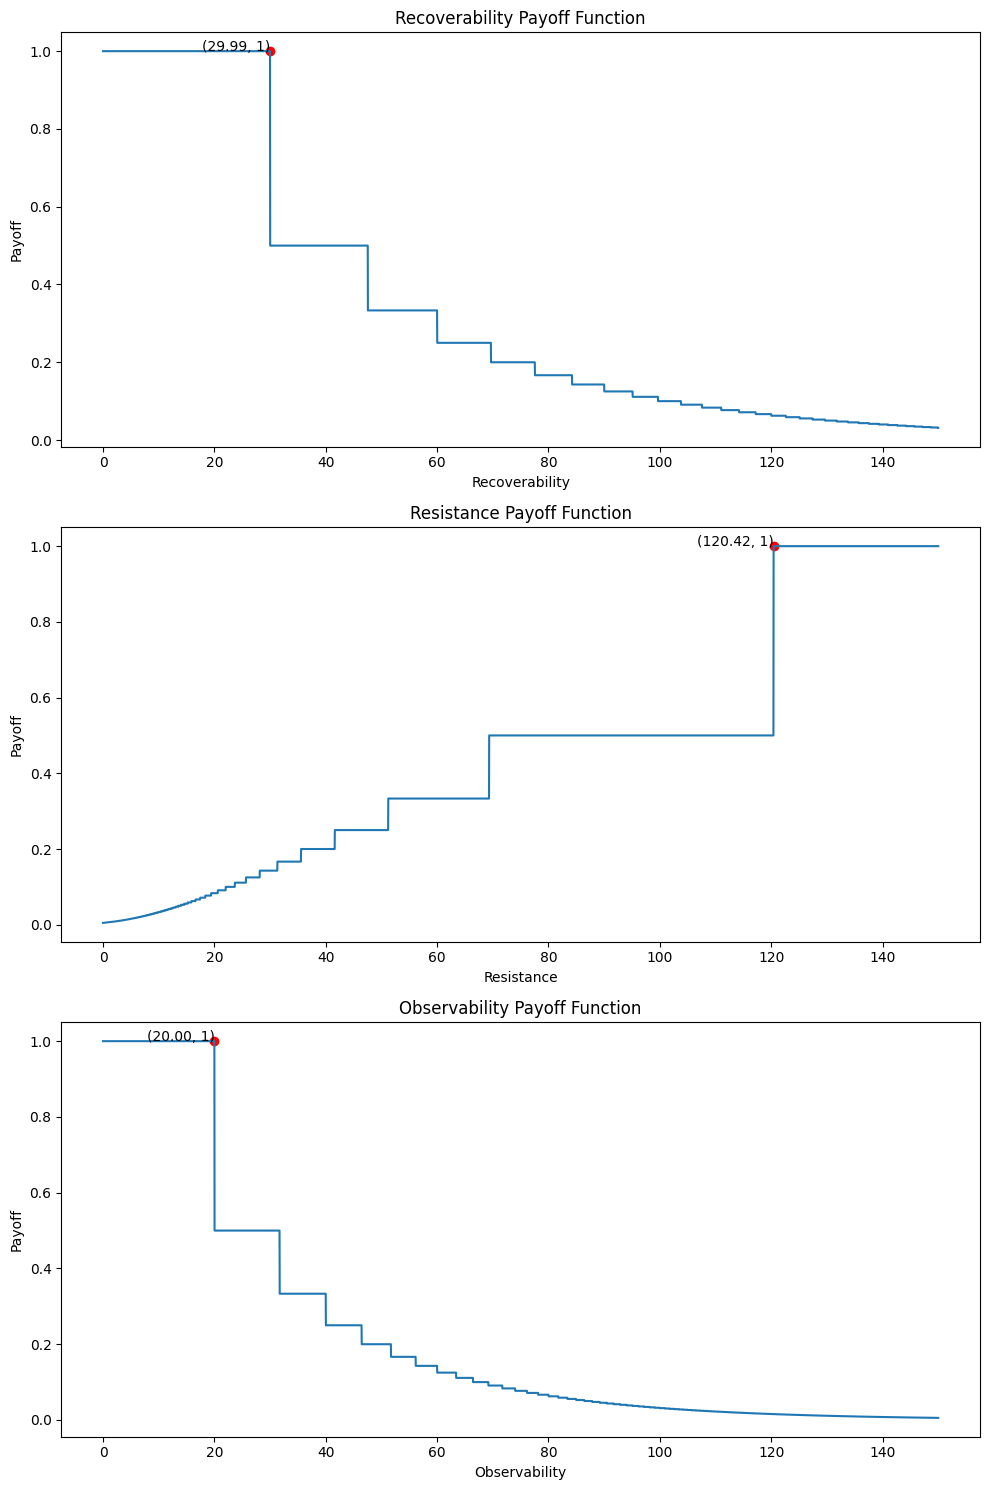

In [43]:

# Generate a range of possible metric values
metric_values = np.linspace(0.001, 150, 10000)  # Adjust this as needed
epsilon = 0.0001  # to avoid division by zero

# Calculate the cost function for each metric
recoverability_cost = np.floor(np.exp(metric_values / (30 / np.log(2))))-1

# expecting most of the recoveries taking between 50 and 140 seconds
# outliers that take longer to recover than the actual chaos time of 120s, should receive an extremely low score
# but should still be measurably better than systems that take even longer
recoverability_payoff = 1 / (1 + np.floor(np.exp(metric_values / (30 / np.log(2))))-1)
# resistance because a trial is 120 seconds, an if it fails at all during that time it should not be perfect
resistance_payoff = 1 / (1 + np.floor(np.exp((66.5 / np.log(2)) / (metric_values + 18)))-1)
# Alert needs to firing for 20 seconds before it is triggered, therefore observability of 20s should be perfect payoff
observability_payoff = 1 / (1 + np.floor(np.exp(metric_values / (20 / np.log(2))))-1)

# Calculate x_values for y=1 (or close to 1)
recoverability_x_for_y1 = metric_values[np.where(recoverability_payoff==1)[0][-1]]
resistance_x_for_y1 = metric_values[np.where(resistance_payoff==1)[0][0]]
observability_x_for_y1 = metric_values[np.where(observability_payoff==1)[0][-1]]

# Plot cost functions
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Recoverability
#ax[0].plot(metric_values, recoverability_cost)
#ax[0].set_title('Recoverability Cost Function')
#ax[0].set_xlabel('Recoverability')
#ax[0].set_ylabel('Cost')

# Recoverability Payoff with point at y=1
ax[0].plot(metric_values, recoverability_payoff)
ax[0].scatter(recoverability_x_for_y1, 1, color='red')  # Add point at y=1
ax[0].text(recoverability_x_for_y1, 1, f'({recoverability_x_for_y1:.2f}, 1)', ha='right')  # Add coordinates
ax[0].set_title('Recoverability Payoff Function')
ax[0].set_xlabel('Recoverability')
ax[0].set_ylabel('Payoff')

# Resistance Payoff with point at y=1
ax[1].plot(metric_values, resistance_payoff)
ax[1].scatter(resistance_x_for_y1, 1, color='red')  # Add point at y=1
ax[1].text(resistance_x_for_y1, 1, f'({resistance_x_for_y1:.2f}, 1)', ha='right')  # Add coordinates
ax[1].set_title('Resistance Payoff Function')
ax[1].set_xlabel('Resistance')
ax[1].set_ylabel('Payoff')

# Observability Payoff with point at y=1
ax[2].plot(metric_values, observability_payoff)
ax[2].scatter(observability_x_for_y1, 1, color='red')  # Add point at y=1
ax[2].text(observability_x_for_y1, 1, f'({observability_x_for_y1:.2f}, 1)', ha='right')  # Add coordinates
ax[2].set_title('Observability Payoff Function')
ax[2].set_xlabel('Observability')
ax[2].set_ylabel('Payoff')

plt.tight_layout()
plt.show()

## Calculate Antifragility Score

In [44]:
print(experiment_data)

             chaosresult_name          start_time       inject_change  \
0     perform_update_1_Trial1 2023-07-15 18:05:27 2023-07-15 18:06:00   
1     perform_update_1_Trial2 2023-07-15 18:08:30 2023-07-15 18:09:03   
2     perform_update_1_Trial3 2023-07-15 18:11:33 2023-07-15 18:12:06   
3     perform_update_1_Trial4 2023-07-15 18:14:36 2023-07-15 18:15:08   
4     perform_update_1_Trial5 2023-07-15 18:17:38 2023-07-15 18:18:11   
..                        ...                 ...                 ...   
135   perform_update_2_Trial6 2023-07-16 16:20:43 2023-07-16 16:21:16   
136   perform_update_2_Trial7 2023-07-16 16:23:46 2023-07-16 16:24:19   
137   perform_update_2_Trial8 2023-07-16 16:26:49 2023-07-16 16:27:21   
138   perform_update_2_Trial9 2023-07-16 16:29:51 2023-07-16 16:30:24   
139  perform_update_2_Trial10 2023-07-16 16:32:54 2023-07-16 16:33:27   

               end_time    type  group fail_init fail_end fail_detect  \
0   2023-07-15 18:08:30  update      0       NaT  

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect,Scalability,Fault Tolerance,Recoverability,Resistance,Observability,Self-Organizing,Blast Radius,Scalability-Payoff,Fault Tolerance-Payoff,Recoverability-Payoff,Resistance-Payoff,Observability-Payoff,BlastRadius-Payoff
0,perform_update_1_Trial1,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,update,0,NaT,NaT,NaT,0.980594,0.988095,nan,1000.000000,nan,1.000000,0,0.980594,0.988095,nan,1.000000,nan,1.000000
1,perform_update_1_Trial2,2023-07-15 18:08:30,2023-07-15 18:09:03,2023-07-15 18:11:33,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0,1.000000,1.000000,nan,1.000000,nan,1.000000
2,perform_update_1_Trial3,2023-07-15 18:11:33,2023-07-15 18:12:06,2023-07-15 18:14:36,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0,1.000000,1.000000,nan,1.000000,nan,1.000000
3,perform_update_1_Trial4,2023-07-15 18:14:36,2023-07-15 18:15:08,2023-07-15 18:17:38,update,0,NaT,NaT,NaT,0.987917,0.982759,nan,1000.000000,nan,1.000000,0,0.987917,0.982759,nan,1.000000,nan,1.000000
4,perform_update_1_Trial5,2023-07-15 18:17:38,2023-07-15 18:18:11,2023-07-15 18:20:41,update,0,NaT,NaT,NaT,0.974047,0.984615,nan,1000.000000,nan,1.000000,0,0.974047,0.984615,nan,1.000000,nan,1.000000
5,perform_update_1_Trial6,2023-07-15 18:20:41,2023-07-15 18:21:14,2023-07-15 18:23:44,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0,1.000000,1.000000,nan,1.000000,nan,1.000000
6,perform_update_1_Trial7,2023-07-15 18:23:44,2023-07-15 18:24:17,2023-07-15 18:26:47,update,0,NaT,NaT,NaT,0.984646,0.984127,nan,1000.000000,nan,1.000000,0,0.984646,0.984127,nan,1.000000,nan,1.000000
7,perform_update_1_Trial8,2023-07-15 18:26:47,2023-07-15 18:27:19,2023-07-15 18:29:49,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0,1.000000,1.000000,nan,1.000000,nan,1.000000
8,perform_update_1_Trial9,2023-07-15 18:29:49,2023-07-15 18:30:22,2023-07-15 18:32:52,update,0,NaT,NaT,NaT,1.000000,1.000000,nan,1000.000000,nan,1.000000,0,1.000000,1.000000,nan,1.000000,nan,1.000000
9,perform_update_1_Trial10,2023-07-15 18:32:52,2023-07-15 18:33:24,2023-07-15 18:35:54,update,0,NaT,NaT,NaT,0.965793,0.970149,nan,1000.000000,nan,1.000000,0,0.965793,0.970149,nan,1.000000,nan,1.000000


In [68]:
# List of columns to calculate the adaptivity for
payoff_metrics = ["Scalability", "Fault Tolerance", "Recoverability", "Resistance", "Observability", "BlastRadius"]

# Initialization of the resulting DataFrame
experiments_summary = pd.DataFrame(columns=["Experimenttype", "Group", "Start_time", "End_time"] + [f"{metric}-Adaptivity" for metric in payoff_metrics])


In [88]:
def calculate_adaptivity_score(experiment_group_data, metric):
    """Calculates adaptivity score for a specific metric."""
    adaptivity_score = 0
    trial_count = 0
    previous_payoff = np.nan
    payoff_column = f"{metric}-Payoff"
    
    for i, current_payoff in enumerate(experiment_group_data[payoff_column]):
        # Skip if the current payoff is NaN
        if np.isnan(current_payoff):
            continue  
        trial_count += 1
        current_payoff = round(current_payoff, 3)  # Round to 3 decimal points
    
        
        if np.isnan(previous_payoff):
            # Find the most recent non-NaN payoff
            previous_payoff = get_previous_payoff(experiment_group_data[payoff_column], i)
        
        
        # Ensure previous_payoff is also rounded to 3 decimal points
        previous_payoff = round(previous_payoff, 3) if not np.isnan(previous_payoff) else np.nan  
        
        
        
        if np.isnan(previous_payoff) or current_payoff == previous_payoff:  # neutral decision
            adaptivity_score += current_payoff
        elif current_payoff > previous_payoff:  # positive decision
            adaptivity_score += (current_payoff + previous_payoff) / 2
        # Negative decisions are ignored
        previous_payoff = current_payoff

    return adaptivity_score, trial_count

def get_previous_payoff(payoff_column_data, current_index):
    """Finds the most recent non-NaN payoff."""
    non_nan_payoffs = payoff_column_data.iloc[:current_index].dropna()
    previous_payoff = non_nan_payoffs.iloc[-1] if not non_nan_payoffs.empty else np.nan
    return previous_payoff

def summarize_experiment(experiment_data):
    """Creates summary for experiments."""
    payoff_metrics = ["Scalability", "Fault Tolerance", "Recoverability", "Resistance", "Observability", "BlastRadius"]
    experiments_summary_list = []
    
    for (experiment_type, group), experiment_group_data in experiment_data.groupby(["type", "group"]):
        experiment_group_data = experiment_group_data.sort_values(by="start_time")
        start_time = experiment_group_data["start_time"].iloc[0]
        end_time = experiment_group_data["end_time"].iloc[-1]
        
        experiment_summary = {"Experimenttype": experiment_type, "Group": group, "Start_time": start_time, "End_time": end_time}
        for metric in payoff_metrics:
            adaptivity_score, trial_count = calculate_adaptivity_score(experiment_group_data, metric)
            adaptivity_score /= trial_count if trial_count != 0 else 1  # Calculate average, avoid division by zero
            if trial_count == 0:  # If all payoffs are NaN
                adaptivity_score = np.nan
            experiment_summary[f"{metric}-Adaptivity"] = adaptivity_score
        
        experiments_summary_list.append(experiment_summary)

    experiments_summary = pd.DataFrame(experiments_summary_list)
    return experiments_summary

# Run the function on the data
experiments_summary = summarize_experiment(experiment_data)

In [89]:
experiments_summary.style

,Experimenttype,Group,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity
0,cpu,0,2023-07-15 23:03:45,2023-07-16 00:05:03,0.491050,0.526250,0.110100,0.297500,0.584100,0.666800
1,cpu,1,2023-07-16 12:01:53,2023-07-16 13:05:09,0.431400,0.529450,0.180111,0.236450,0.228667,0.711200
2,delete,0,2023-07-16 07:33:25,2023-07-16 08:54:38,0.393050,0.493450,nan,1.000000,nan,0.894450
3,load,0,2023-07-15 18:50:13,2023-07-15 19:40:15,0.530150,0.632000,0.070222,0.246350,0.875000,0.755700
4,load,1,2023-07-16 09:24:01,2023-07-16 10:14:03,0.638150,0.658250,0.199750,0.525800,0.296875,0.722300
5,memory,0,2023-07-16 00:35:51,2023-07-16 01:37:07,0.575800,0.584650,0.164900,0.627250,0.000000,0.777800
6,memory,1,2023-07-16 01:43:47,2023-07-16 02:45:03,0.684400,0.687800,0.666667,0.750000,0.000000,0.427950
7,memory,2,2023-07-16 13:40:51,2023-07-16 14:42:09,0.587000,0.590800,0.273250,0.741650,0.000000,0.788900
8,memory,3,2023-07-16 14:47:02,2023-07-16 15:48:19,0.582150,0.591800,0.500000,0.866650,0.000000,0.578000
9,network,0,2023-07-15 19:56:00,2023-07-15 21:03:24,0.581700,0.590150,0.295875,0.501850,0.125000,0.444350


In [90]:
experiments_summary.sort_values(by="Start_time").style

,Experimenttype,Group,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity
12,update,0,2023-07-15 18:05:27,2023-07-15 18:35:54,0.595100,0.695050,nan,1.000000,nan,1.000000
3,load,0,2023-07-15 18:50:13,2023-07-15 19:40:15,0.530150,0.632000,0.070222,0.246350,0.875000,0.755700
9,network,0,2023-07-15 19:56:00,2023-07-15 21:03:24,0.581700,0.590150,0.295875,0.501850,0.125000,0.444350
10,network,1,2023-07-15 21:20:46,2023-07-15 22:38:16,0.595550,0.596800,0.244333,0.583500,0.000000,1.000000
0,cpu,0,2023-07-15 23:03:45,2023-07-16 00:05:03,0.491050,0.526250,0.110100,0.297500,0.584100,0.666800
5,memory,0,2023-07-16 00:35:51,2023-07-16 01:37:07,0.575800,0.584650,0.164900,0.627250,0.000000,0.777800
6,memory,1,2023-07-16 01:43:47,2023-07-16 02:45:03,0.684400,0.687800,0.666667,0.750000,0.000000,0.427950
2,delete,0,2023-07-16 07:33:25,2023-07-16 08:54:38,0.393050,0.493450,nan,1.000000,nan,0.894450
4,load,1,2023-07-16 09:24:01,2023-07-16 10:14:03,0.638150,0.658250,0.199750,0.525800,0.296875,0.722300
11,network,2,2023-07-16 10:30:47,2023-07-16 11:45:09,0.696100,0.697050,1.000000,0.851850,0.000000,0.900000


In [91]:
experiment_data.describe()

,start_time,inject_change,end_time,group,fail_init,fail_end,fail_detect,Scalability,Fault Tolerance,Recoverability,Resistance,Observability,Self-Organizing,Blast Radius,Scalability-Payoff,Fault Tolerance-Payoff,Recoverability-Payoff,Resistance-Payoff,Observability-Payoff,BlastRadius-Payoff
count,140,140,140,140.000000,56,55,31,140.000000,140.000000,55.000000,140.000000,56.000000,140.000000,140.000000,140.000000,140.000000,55.000000,140.000000,5.600000e+01,140.000000
mean,2023-07-16 05:16:31.221428480,2023-07-16 05:18:35.135714304,2023-07-16 05:21:57.214285824,0.857143,2023-07-16 03:17:48.392857088,2023-07-16 03:28:28,2023-07-16 01:47:52.903225856,0.951314,0.965351,110.181818,626.157143,456.250000,0.889190,1.021429,0.951314,0.965351,0.312708,0.757285,4.129187e-01,0.886508
min,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,0.000000,2023-07-15 18:52:40,2023-07-15 18:54:50,2023-07-15 18:52:40,0.611587,0.773333,10.000000,2.000000,0.000000,0.030303,0.000000,0.611587,0.773333,0.001957,0.008264,8.881784e-16,0.222222
25%,2023-07-15 21:54:14.750000128,2023-07-15 21:56:30,2023-07-15 21:59:47.750000128,0.000000,2023-07-15 21:11:45,2023-07-15 21:34:30,2023-07-15 19:29:25,0.933132,0.951952,40.000000,75.500000,0.000000,1.000000,0.000000,0.933132,0.951952,0.022500,0.500000,8.881784e-16,0.777778
50%,2023-07-16 05:06:29,2023-07-16 05:10:03.500000,2023-07-16 05:12:56,1.000000,2023-07-16 00:41:25,2023-07-16 00:46:30,2023-07-15 23:32:50,0.981353,0.984845,110.000000,1000.000000,60.000000,1.000000,0.000000,0.981353,0.984845,0.083333,1.000000,1.454545e-01,1.000000
75%,2023-07-16 12:28:12,2023-07-16 12:30:27,2023-07-16 12:33:42.750000128,1.000000,2023-07-16 10:07:12.500000,2023-07-16 10:09:35,2023-07-16 09:33:00,1.000000,1.000000,165.000000,1000.000000,1000.000000,1.000000,2.000000,1.000000,1.000000,0.500000,1.000000,1.000000e+00,1.000000
max,2023-07-16 16:32:54,2023-07-16 16:33:27,2023-07-16 16:35:57,3.000000,2023-07-16 15:02:40,2023-07-16 15:03:10,2023-07-16 13:02:20,1.000000,1.000000,270.000000,1000.000000,1000.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
std,NaN,NaN,NaN,0.918017,NaN,NaN,NaN,0.070002,0.044732,79.802787,460.333055,493.166254,0.241656,1.481142,0.070002,0.044732,0.391725,0.357364,4.536189e-01,0.164571


## Group by system

In [108]:
system_switch= pd.to_datetime("2023-07-16 08:54:38")
column_index = experiments_summary.columns.get_loc('Group')+1
experiments_summary.insert(column_index, 'System', None)


In [110]:
experiments_summary['System'] = np.where(experiments_summary['Start_time'] < system_switch, 0, 1)

In [111]:
experiments_summary.style

,Experimenttype,Group,System,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity
0,cpu,0,0,2023-07-15 23:03:45,2023-07-16 00:05:03,0.491050,0.526250,0.110100,0.297500,0.584100,0.666800
1,cpu,1,1,2023-07-16 12:01:53,2023-07-16 13:05:09,0.431400,0.529450,0.180111,0.236450,0.228667,0.711200
2,delete,0,0,2023-07-16 07:33:25,2023-07-16 08:54:38,0.393050,0.493450,nan,1.000000,nan,0.894450
3,load,0,0,2023-07-15 18:50:13,2023-07-15 19:40:15,0.530150,0.632000,0.070222,0.246350,0.875000,0.755700
4,load,1,1,2023-07-16 09:24:01,2023-07-16 10:14:03,0.638150,0.658250,0.199750,0.525800,0.296875,0.722300
5,memory,0,0,2023-07-16 00:35:51,2023-07-16 01:37:07,0.575800,0.584650,0.164900,0.627250,0.000000,0.777800
6,memory,1,0,2023-07-16 01:43:47,2023-07-16 02:45:03,0.684400,0.687800,0.666667,0.750000,0.000000,0.427950
7,memory,2,1,2023-07-16 13:40:51,2023-07-16 14:42:09,0.587000,0.590800,0.273250,0.741650,0.000000,0.788900
8,memory,3,1,2023-07-16 14:47:02,2023-07-16 15:48:19,0.582150,0.591800,0.500000,0.866650,0.000000,0.578000
9,network,0,0,2023-07-15 19:56:00,2023-07-15 21:03:24,0.581700,0.590150,0.295875,0.501850,0.125000,0.444350


In [125]:
system_1 = experiments_summary[experiments_summary['System']==0]
system_2 = experiments_summary[experiments_summary['System']==1]

In [126]:
system_1 = system_1.drop(system_1[(system_1['Experimenttype']=="network") & (system_1['Group']==0)].index)

In [127]:
system_1

,Experimenttype,Group,System,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity
0,cpu,0,0,2023-07-15 23:03:45,2023-07-16 00:05:03,0.49105,0.52625,0.110100,0.29750,0.5841,0.66680
2,delete,0,0,2023-07-16 07:33:25,2023-07-16 08:54:38,0.39305,0.49345,NaN,1.00000,NaN,0.89445
3,load,0,0,2023-07-15 18:50:13,2023-07-15 19:40:15,0.53015,0.63200,0.070222,0.24635,0.8750,0.75570
5,memory,0,0,2023-07-16 00:35:51,2023-07-16 01:37:07,0.57580,0.58465,0.164900,0.62725,0.0000,0.77780
6,memory,1,0,2023-07-16 01:43:47,2023-07-16 02:45:03,0.68440,0.68780,0.666667,0.75000,0.0000,0.42795
10,network,1,0,2023-07-15 21:20:46,2023-07-15 22:38:16,0.59555,0.59680,0.244333,0.58350,0.0000,1.00000
12,update,0,0,2023-07-15 18:05:27,2023-07-15 18:35:54,0.59510,0.69505,NaN,1.00000,NaN,1.00000


In [129]:
system_2.describe()

,Group,System,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity
count,6.000000,6.0,6,6,6.000000,6.000000,5.000000,6.000000,5.000000,6.000000
mean,1.666667,1.0,2023-07-16 12:45:00.666666240,2023-07-16 13:41:47.666666496,0.639042,0.661108,0.430622,0.703733,0.105108,0.765808
min,1.000000,1.0,2023-07-16 09:24:01,2023-07-16 10:14:03,0.431400,0.529450,0.180111,0.236450,0.000000,0.578000
25%,1.000000,1.0,2023-07-16 10:53:33.500000,2023-07-16 12:05:09,0.583363,0.591050,0.199750,0.579763,0.000000,0.713975
50%,1.500000,1.0,2023-07-16 12:51:22,2023-07-16 13:53:39,0.612575,0.625025,0.273250,0.796750,0.000000,0.755600
75%,2.000000,1.0,2023-07-16 14:30:29.249999872,2023-07-16 15:31:46.500000,0.681613,0.687350,0.500000,0.862950,0.228667,0.868062
max,3.000000,1.0,2023-07-16 16:05:30,2023-07-16 16:35:57,0.899450,0.899300,1.000000,1.000000,0.296875,0.900000
std,0.816497,0.0,NaN,NaN,0.155003,0.130473,0.342720,0.278462,0.145932,0.122667


In [143]:
def calculate_summary(data, system_name):
    summary_columns = ["Scalability-Adaptivity", "Fault Tolerance-Adaptivity", "Recoverability-Adaptivity", "Resistance-Adaptivity", "Observability-Adaptivity", "BlastRadius-Adaptivity"]

    # Calculate the mean and standard deviation for each column
    mean = data[summary_columns].mean()
    std_dev = data[summary_columns].std()

    # Create a DataFrame from these and add a 'System' column
    summary = pd.DataFrame(data=[mean, std_dev], index=['mean', 'std_dev'])
    summary['System'] = system_name
    return summary

# Calculate summaries for each system
summary_system_1 = calculate_summary(system_1, 'System 1')
summary_system_2 = calculate_summary(system_2, 'System 2')

# Concatenate these summaries into one DataFrame
summary_table = pd.concat([summary_system_1, summary_system_2])

# Rearrange columns
summary_table = summary_table[['System'] + summary_columns]

In [144]:
summary_table.style

,System,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity
mean,System 1,0.552157,0.602286,0.251244,0.643514,0.291820,0.788957
std_dev,System 1,0.092473,0.076123,0.241231,0.301893,0.412615,0.202767
mean,System 2,0.639042,0.661108,0.430622,0.703733,0.105108,0.765808
std_dev,System 2,0.155003,0.130473,0.342720,0.278462,0.145932,0.122667


In [145]:
print(system_1)

   Experimenttype  Group  System          Start_time            End_time  \
0             cpu      0       0 2023-07-15 23:03:45 2023-07-16 00:05:03   
2          delete      0       0 2023-07-16 07:33:25 2023-07-16 08:54:38   
3            load      0       0 2023-07-15 18:50:13 2023-07-15 19:40:15   
5          memory      0       0 2023-07-16 00:35:51 2023-07-16 01:37:07   
6          memory      1       0 2023-07-16 01:43:47 2023-07-16 02:45:03   
10        network      1       0 2023-07-15 21:20:46 2023-07-15 22:38:16   
12         update      0       0 2023-07-15 18:05:27 2023-07-15 18:35:54   

    Scalability-Adaptivity  Fault Tolerance-Adaptivity  \
0                  0.49105                     0.52625   
2                  0.39305                     0.49345   
3                  0.53015                     0.63200   
5                  0.57580                     0.58465   
6                  0.68440                     0.68780   
10                 0.59555                 

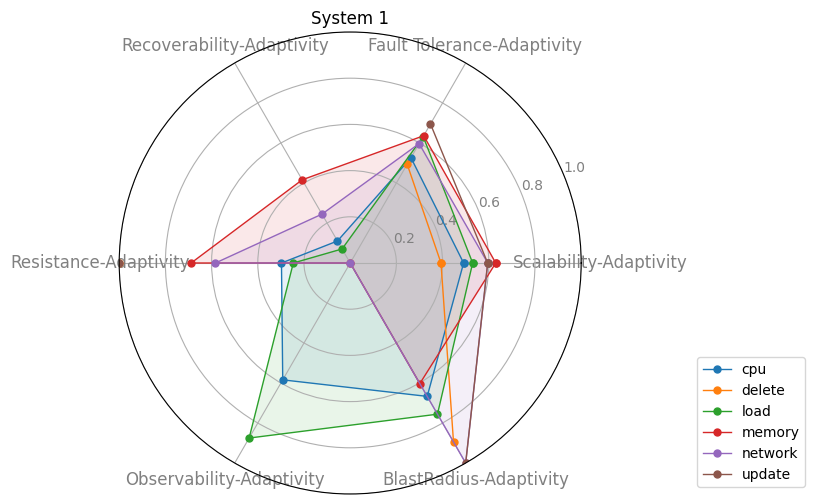

In [189]:
# Select relevant columns
data = system_1[["Experimenttype", "Scalability-Adaptivity", "Fault Tolerance-Adaptivity",
                      "Recoverability-Adaptivity", "Resistance-Adaptivity", "Observability-Adaptivity", 
                      "BlastRadius-Adaptivity"]]

# Aggregate data by Experimenttype and take the mean
data = data.groupby('Experimenttype').mean().reset_index()

# Number of variable
categories = list(data)[1:]
N = len(categories)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]  # Ensure the plot is a complete circle

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Loop to add each experimenttype to the plot
for i, row in data.iterrows():
    values = row.drop('Experimenttype').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', marker='o', markersize=5, label=row['Experimenttype'])
    ax.fill(angles, values, alpha=0.1)

# Add legend and labels
plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(color="grey", size=10)
plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))
plt.title("System 1")

# Set radial axis limits
ax.set_ylim(0, 1)

plt.show()


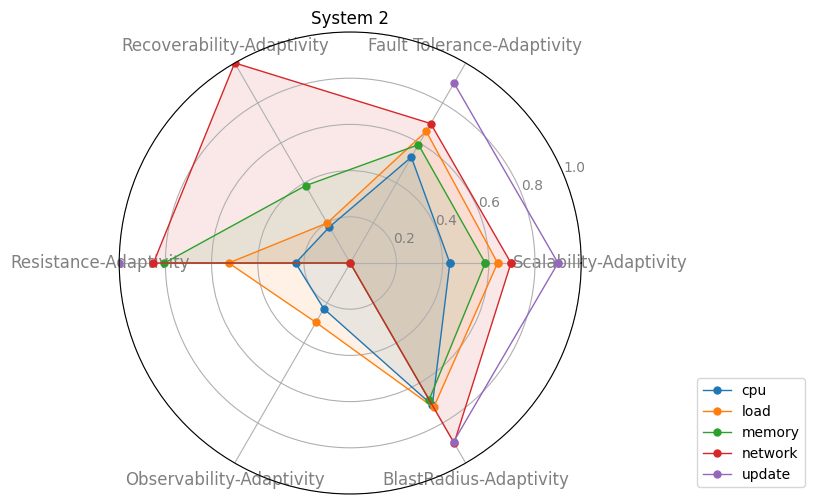

In [190]:
# Select relevant columns
data = system_2[["Experimenttype", "Scalability-Adaptivity", "Fault Tolerance-Adaptivity",
                      "Recoverability-Adaptivity", "Resistance-Adaptivity", "Observability-Adaptivity", 
                      "BlastRadius-Adaptivity"]]

# Aggregate data by Experimenttype and take the mean
data = data.groupby('Experimenttype').mean().reset_index()

# Number of variable
categories = list(data)[1:]
N = len(categories)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]  # Ensure the plot is a complete circle

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Loop to add each experimenttype to the plot
for i, row in data.iterrows():
    values = row.drop('Experimenttype').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', marker='o', markersize=5, label=row['Experimenttype'])
    ax.fill(angles, values, alpha=0.1)

# Add legend and labels
plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(color="grey", size=10)
plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))
plt.title("System 2")

# Set radial axis limits
ax.set_ylim(0, 1)

plt.show()


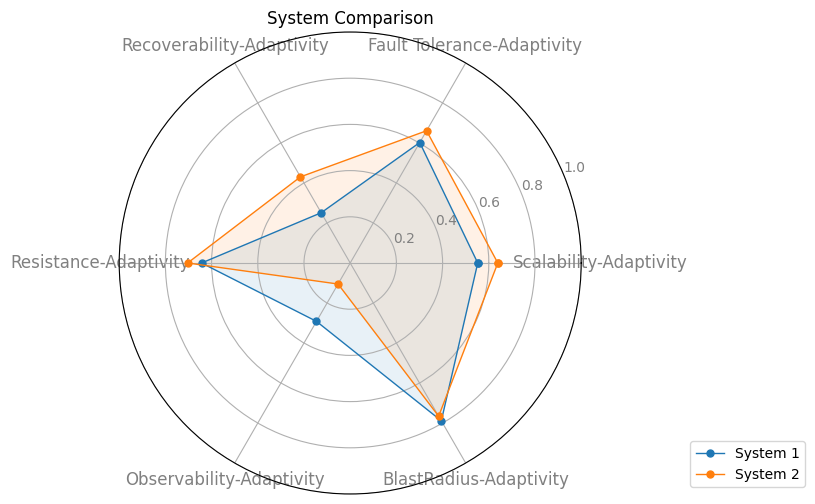

In [196]:
# Select relevant columns
data = summary_table[["System", "Scalability-Adaptivity", "Fault Tolerance-Adaptivity",
                      "Recoverability-Adaptivity", "Resistance-Adaptivity", "Observability-Adaptivity", 
                      "BlastRadius-Adaptivity"]]

# Drop rows with label "std_dev"
data = data.drop('std_dev', axis=0)

# Aggregate data by Experimenttype and take the mean
data = data.groupby('System').mean().reset_index()

# Number of variable
categories = list(data)[1:]
N = len(categories)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]  # Ensure the plot is a complete circle

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Loop to add each experimenttype to the plot
for i, row in data.iterrows():
    values = row.drop('System').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', marker='o', markersize=5, label=row['System'])
    ax.fill(angles, values, alpha=0.1)

# Add legend and labels
plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(color="grey", size=10)
plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))
plt.title("System Comparison")

# Set radial axis limits
ax.set_ylim(0, 1)

plt.show()


In [197]:
summary_table.style

,System,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity
mean,System 1,0.552157,0.602286,0.251244,0.643514,0.291820,0.788957
std_dev,System 1,0.092473,0.076123,0.241231,0.301893,0.412615,0.202767
mean,System 2,0.639042,0.661108,0.430622,0.703733,0.105108,0.765808
std_dev,System 2,0.155003,0.130473,0.342720,0.278462,0.145932,0.122667


In [198]:
print(summary_table)

           System  Scalability-Adaptivity  Fault Tolerance-Adaptivity  \
mean     System 1                0.552157                    0.602286   
std_dev  System 1                0.092473                    0.076123   
mean     System 2                0.639042                    0.661108   
std_dev  System 2                0.155003                    0.130473   

         Recoverability-Adaptivity  Resistance-Adaptivity  \
mean                      0.251244               0.643514   
std_dev                   0.241231               0.301893   
mean                      0.430622               0.703733   
std_dev                   0.342720               0.278462   

         Observability-Adaptivity  BlastRadius-Adaptivity  
mean                     0.291820                0.788957  
std_dev                  0.412615                0.202767  
mean                     0.105108                0.765808  
std_dev                  0.145932                0.122667  


In [212]:
final_score = summary_table
final_score = final_score.drop('std_dev', axis=0)
final_score['Antifragility-Score'] = final_score.loc[:, 'Scalability-Adaptivity':'BlastRadius-Adaptivity'].mean(axis=1)
final_score['Antifragility-Score-Std_dev'] = final_score.loc[:, 'Scalability-Adaptivity':'BlastRadius-Adaptivity'].std(axis=1)

In [213]:
final_score.style

,System,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Antifragility-Score,Antifragility-Score-Std_dev
mean,System 1,0.552157,0.602286,0.251244,0.643514,0.291820,0.788957,0.521663,0.209608
mean,System 2,0.639042,0.661108,0.430622,0.703733,0.105108,0.765808,0.550904,0.246031


In [216]:
experiment_data[experiment_data['type']=='cpu'].style

,chaosresult_name,start_time,inject_change,end_time,type,group,system,fail_init,fail_end,fail_detect,Scalability,Fault Tolerance,Recoverability,Resistance,Observability,Self-Organizing,Blast Radius,Scalability-Payoff,Fault Tolerance-Payoff,Recoverability-Payoff,Resistance-Payoff,Observability-Payoff,BlastRadius-Payoff
40,pod-cpu-hog-v3p5bwbk-pod-cpu-hog,2023-07-15 23:03:45,2023-07-15 23:06:01,2023-07-15 23:09:15,cpu,0,0,2023-07-15 23:06:50,2023-07-15 23:07:00,2023-07-15 23:07:10,0.795109,0.836538,10.000000,49.000000,20.000000,0.030303,1,0.795109,0.836538,1.000000,0.250000,0.500000,0.888889
41,pod-cpu-hog-y53vjl6b-pod-cpu-hog,2023-07-15 23:09:57,2023-07-15 23:12:12,2023-07-15 23:15:27,cpu,0,0,2023-07-15 23:14:20,2023-07-15 23:16:30,2023-07-15 23:12:40,0.925599,0.933333,130.000000,128.000000,0.000000,0.696970,1,0.925599,0.933333,0.050000,1.000000,1.000000,0.888889
42,pod-cpu-hog-zwrshgkr-pod-cpu-hog,2023-07-15 23:16:10,2023-07-15 23:18:25,2023-07-15 23:21:39,cpu,0,0,2023-07-15 23:19:00,2023-07-15 23:21:40,2023-07-15 23:19:00,0.849574,0.888889,160.000000,35.000000,0.000000,0.486322,2,0.849574,0.888889,0.025000,0.166667,1.000000,0.777778
43,pod-cpu-hog-1lyfsbkd-pod-cpu-hog,2023-07-15 23:22:22,2023-07-15 23:24:37,2023-07-15 23:27:52,cpu,0,0,2023-07-15 23:25:30,2023-07-15 23:27:10,NaT,0.898489,0.935780,100.000000,53.000000,1000.000000,1.000000,1,0.898489,0.935780,0.100000,0.333333,0.000000,0.888889
44,pod-cpu-hog-39bpcttl-pod-cpu-hog,2023-07-15 23:28:34,2023-07-15 23:30:50,2023-07-15 23:34:04,cpu,0,0,2023-07-15 23:31:40,2023-07-15 23:35:20,2023-07-15 23:32:50,0.800449,0.858586,220.000000,50.000000,70.000000,0.454545,1,0.800449,0.858586,0.006211,0.250000,0.090909,0.888889
45,pod-cpu-hog-4z649dhv-pod-cpu-hog,2023-07-15 23:34:46,2023-07-15 23:37:01,2023-07-15 23:40:16,cpu,0,0,2023-07-15 23:37:40,2023-07-15 23:41:40,2023-07-15 23:37:30,0.799837,0.855556,240.000000,39.000000,0.000000,0.757576,2,0.799837,0.855556,0.003922,0.200000,1.000000,0.777778
46,pod-cpu-hog-7oyr7h5g-pod-cpu-hog,2023-07-15 23:40:58,2023-07-15 23:43:13,2023-07-15 23:46:28,cpu,0,0,2023-07-15 23:44:40,2023-07-15 23:49:00,2023-07-15 23:44:00,0.839284,0.866667,260.000000,87.000000,0.000000,0.909091,2,0.839284,0.866667,0.002463,0.500000,1.000000,0.777778
47,pod-cpu-hog-9o7lzbf5-pod-cpu-hog,2023-07-15 23:47:09,2023-07-15 23:49:25,2023-07-15 23:52:39,cpu,0,0,2023-07-15 23:51:00,2023-07-15 23:53:40,2023-07-15 23:49:50,0.765633,0.862500,160.000000,95.000000,0.000000,0.696970,2,0.765633,0.862500,0.025000,0.500000,1.000000,0.777778
48,pod-cpu-hog-bquk5dwr-pod-cpu-hog,2023-07-15 23:53:21,2023-07-15 23:55:36,2023-07-15 23:58:51,cpu,0,0,2023-07-15 23:57:20,2023-07-16 00:00:00,2023-07-15 23:56:00,0.713057,0.876404,160.000000,104.000000,0.000000,0.727273,2,0.713057,0.876404,0.025000,0.500000,1.000000,0.777778
49,pod-cpu-hog-du7t5wrx-pod-cpu-hog,2023-07-15 23:59:33,2023-07-16 00:01:48,2023-07-16 00:05:03,cpu,0,0,2023-07-16 00:03:00,2023-07-16 00:05:50,2023-07-16 00:04:20,0.809567,0.917526,170.000000,72.000000,80.000000,0.272727,1,0.809567,0.917526,0.020000,0.500000,0.066667,0.888889
